Import libraries

In [26]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Load the image and convert it to grayscale. Show original image

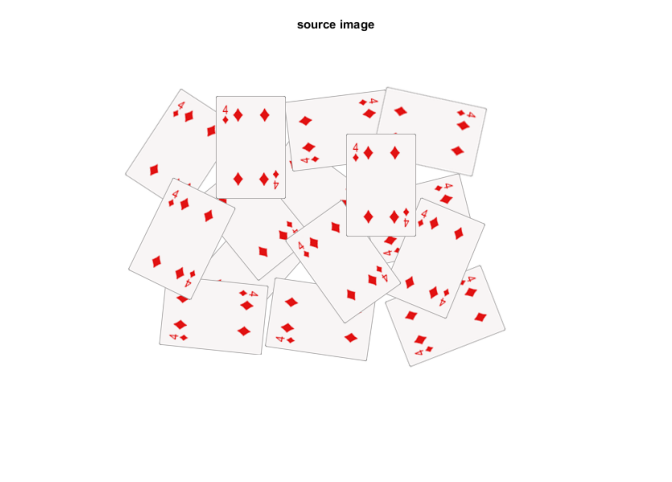

In [31]:
image = cv2.imread('image_path.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Apply a binary threshold to the image

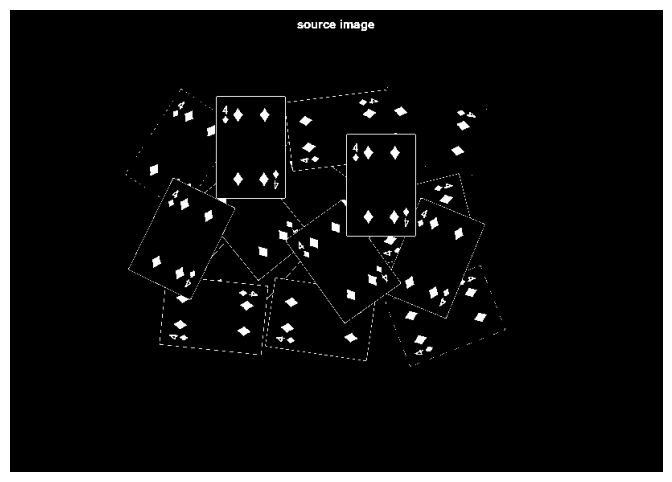

In [18]:
# TODO: use scikit-image instead

_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.figure(figsize=(10, 6))
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

Remove noise using morphological operations

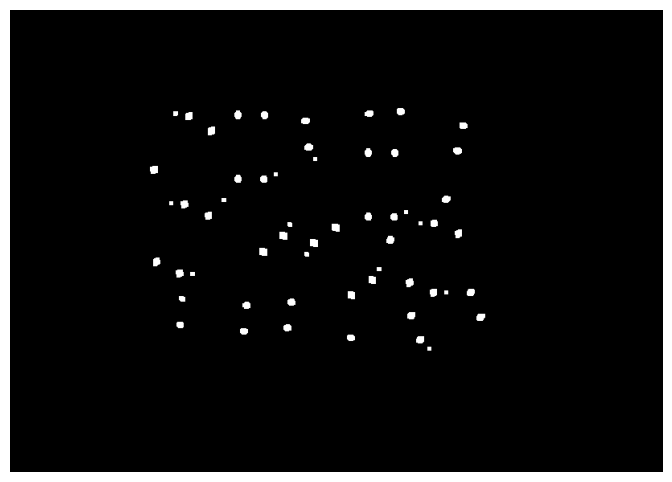

In [19]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

plt.figure(figsize=(10, 6))
plt.imshow(opening, cmap='gray')
plt.axis('off')
plt.show()

Get sure background area using dilation

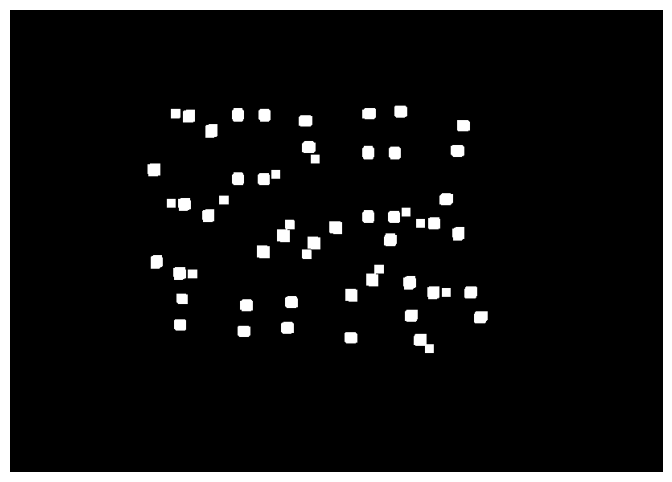

In [20]:
sure_bg = cv2.dilate(opening, kernel, iterations=3)

plt.figure(figsize=(10, 6))
plt.imshow(sure_bg, cmap='gray')
plt.axis('off')
plt.show()

Perform distance transform and thresholding to find sure foreground area

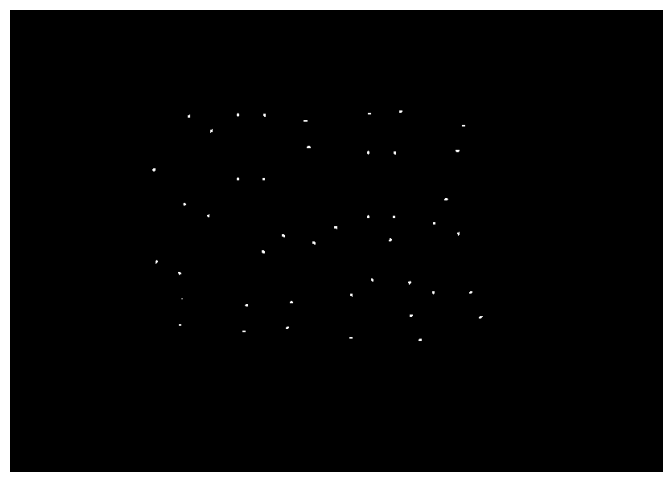

In [21]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

plt.figure(figsize=(10, 6))
plt.imshow(sure_fg, cmap='gray')
plt.axis('off')
plt.show()

Find unknown region (area that is neither background nor foreground)

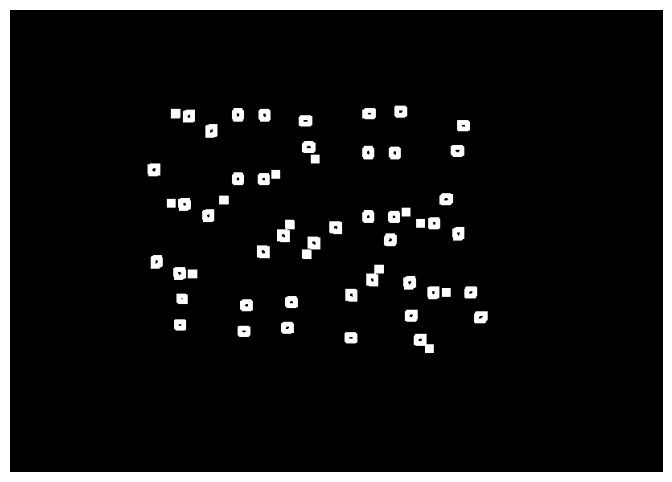

In [22]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.figure(figsize=(10, 6))
plt.imshow(unknown, cmap='gray')
plt.axis('off')
plt.show()

Perform marker labeling

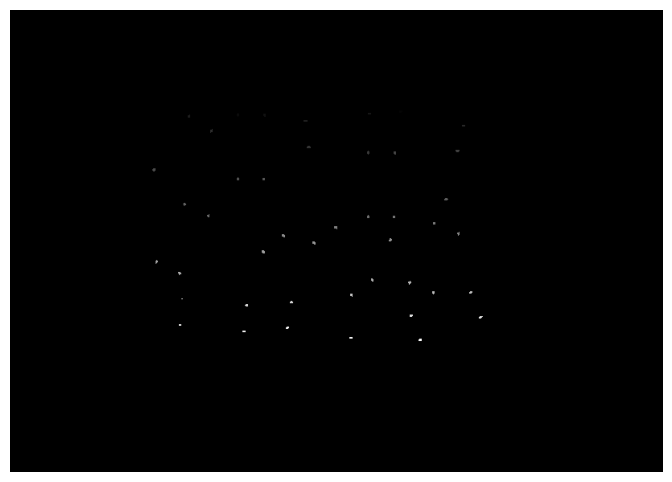

In [23]:
_, markers = cv2.connectedComponents(sure_fg)

Add one to all labels to distinguish sure background from unknown regions

In [9]:
markers = markers + 1

Mark the unknown region with zero

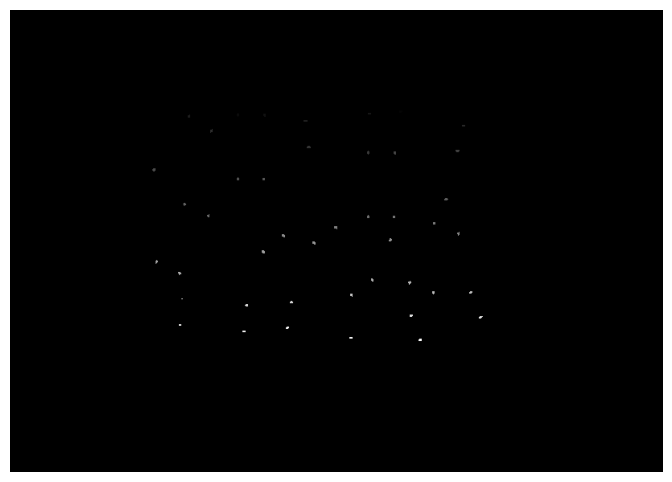

In [24]:
markers[unknown == 255] = 0

Apply the watershed algorithm

In [11]:
markers = cv2.watershed(image, markers)

Mark boundaries in the original image

In [12]:
image[markers == -1] = [0, 255, 0]  # Green boundaries

Display the result

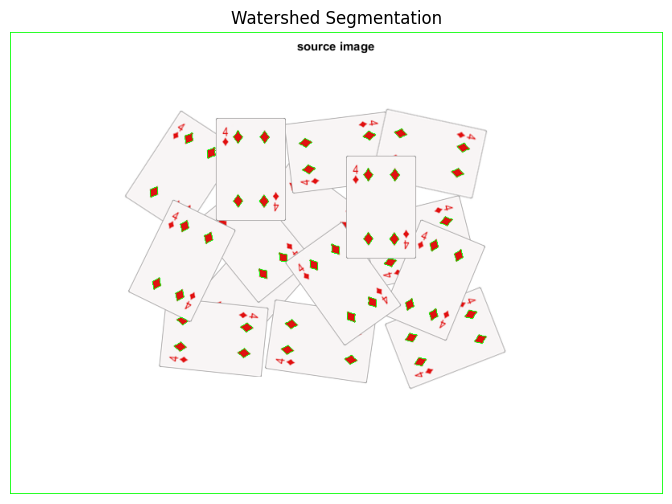

In [13]:
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Watershed Segmentation')
plt.show()